In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

<ul>
    <li>ID – уникальный номер абонента</li>
<li>SUBS_ACTIVATION_DATE_KEY – дата активации сим-карты</li>
<li>REVENUE_TOTAL – расходы абонента за месяц, грн</li>
<li>REVENUE_VOICE – расходы абонента на голосовые услуги за месяц, грн</li>
<li>REVENUE_DATA – расходы абонента на услугу передачи данных за месяц, грн</li>
<li>TRAFFIC_DATA – трафик передачи данных за месяц, мегабайт</li>
<li>MOU – голосовой трафик абонента за месяц, минут</li>
<li>MARKET_KEY – регион абонента со следующими кодами</li> </ul>

## Задание:
<ol>
<li>Проведите сегментацию абонентов на основании предоставленных данных</li>
<li>Объясните, какие показатели вы выбрали в качестве основы для сегментации и почему?</li>
<li>Подготовьте презентацию в Power Point (на английском языке), которая будет демонстрировать полученные результаты (выделенные сегменты, их характеристику и динамику)</li>
<li>Сформулируйте гипотезы и выводы на основании полученной информации</li></ol>

In [3]:
df_aug = pd.read_csv('aug2015.csv', index_col=0)
df_sep = pd.read_csv('sep2015.csv', index_col=0)

df_aug.head()

,SUBS_ACTIVATION_DATE_KEY,REVENUE_TOTAL,REVENUE_VOICE,REVENUE_DATA,TRAFFIC_DATA,MARKET_KEY,MOU
ID,,,,,,,
1,12/2/2011 0:00,11.075,6.562,4.513,0.247,KHR,40.250
2,12/27/2012 0:00,1940.036,1090.420,1.402,0.077,KHR,445.882
3,11/21/2010 0:00,1127.000,631.242,0.000,0.000,PLT,333.233
4,2/15/2012 0:00,142.286,142.286,0.000,0.000,SUM,479.000
5,8/1/2006 0:00,473.233,169.661,44.643,0.000,PLT,131.884


In [4]:
df_aug.describe()

,REVENUE_TOTAL,REVENUE_VOICE,REVENUE_DATA,TRAFFIC_DATA,MOU
count,959.000000,959.000000,959.000000,959.000000,959.000000
mean,920.750579,487.013005,238.741911,288.345119,319.182648
std,3554.652556,713.225269,3442.259779,1401.879960,411.832858
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,143.031500,33.044500,0.000000,0.000000,42.099500
50%,484.213000,249.447000,0.000000,0.000000,173.966000
75%,1104.009000,677.611500,26.513500,4.121500,437.392000
max,106166.820000,7209.236000,106166.820000,26869.049000,2887.349000


In [5]:
df_sep.describe()

,REVENUE_TOTAL,REVENUE_VOICE,REVENUE_DATA,TRAFFIC_DATA,MOU
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,730.716950,415.170542,126.508176,335.293031,296.477948
std,1037.394271,718.883896,431.594084,1597.668025,438.868645
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.656000,8.062500,0.000000,0.000000,28.791000
50%,388.749000,162.545000,0.000000,0.000000,135.533000
75%,1060.259000,533.732500,10.991000,3.351500,369.358000
max,11858.200000,9270.285000,8033.232000,23433.421000,4336.317000


## EXPLORATORY DATA ANALYSIS

In [6]:
for df in [df_aug, df_sep]:
    # transforming SUBS_ACTIVATION col to a date object type
    df['SUBS_ACTIVATION_DATE_KEY'] = df['SUBS_ACTIVATION_DATE_KEY'].apply(lambda x: x.split()[0])
    df['SUBS_ACTIVATION_DATE_KEY'] = pd.to_datetime(df['SUBS_ACTIVATION_DATE_KEY'])
    
    # adding extra feature REVENUE_OTHER for not mentioned sources of revenue from a customer
    df['REVENUE_OTHER'] = round(df['REVENUE_TOTAL'] - df['REVENUE_VOICE'] - df['REVENUE_DATA'], 3)
    df.loc[df[df['REVENUE_OTHER']<0].index, 'REVENUE_OTHER'] = 0

df_aug.head()

,SUBS_ACTIVATION_DATE_KEY,REVENUE_TOTAL,REVENUE_VOICE,REVENUE_DATA,TRAFFIC_DATA,MARKET_KEY,MOU,REVENUE_OTHER
ID,,,,,,,,
1,2011-12-02,11.075,6.562,4.513,0.247,KHR,40.250,-0.000
2,2012-12-27,1940.036,1090.420,1.402,0.077,KHR,445.882,848.214
3,2010-11-21,1127.000,631.242,0.000,0.000,PLT,333.233,495.758
4,2012-02-15,142.286,142.286,0.000,0.000,SUM,479.000,0.000
5,2006-08-01,473.233,169.661,44.643,0.000,PLT,131.884,258.929


In [7]:
print(df_aug.shape, df_sep.shape)

(959, 8) (1059, 8)


September's df contains 100 more observations than the August's one. Let's see how many ID's are in both datasets and how many are unique

In [8]:
aug_customers = set(df_aug.index)
sep_customers = set(df_sep.index)
in_both = aug_customers.intersection(sep_customers)
only_sep = sep_customers - in_both

print(f'Both August & September observations - {len(in_both)} customers \n'\
        f'September only observations - {len(only_sep)} customers')

Both August & September observations - 959 customers 
September only observations - 100 customers


In [9]:
df_sep = df_sep.loc[in_both, :]

Excluding 100 extra observations from the Septmeber dataset and doing further analysis with observations present in both months

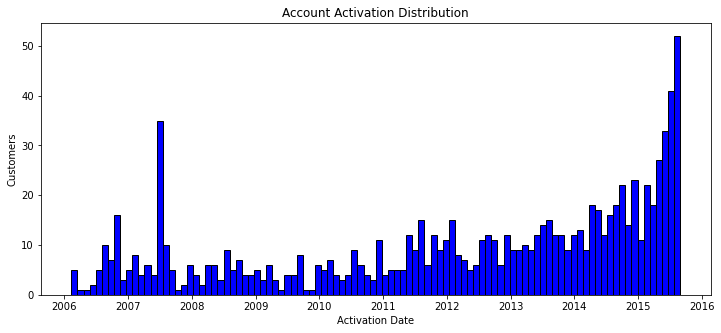

In [10]:
plt.figure(figsize=(12,5))
plt.hist(df_aug['SUBS_ACTIVATION_DATE_KEY'], color = 'blue', edgecolor = 'black',
         bins = 100)
plt.xlabel('Activation Date')
plt.ylabel('Customers')
plt.title('Account Activation Distribution')
plt.show()

## OUTLIERS CHECK

### August QQ plots

In [11]:
features = df_aug.select_dtypes(include=np.number).columns
features

Index(['REVENUE_TOTAL', 'REVENUE_VOICE', 'REVENUE_DATA', 'TRAFFIC_DATA', 'MOU',
       'REVENUE_OTHER'],
      dtype='object')

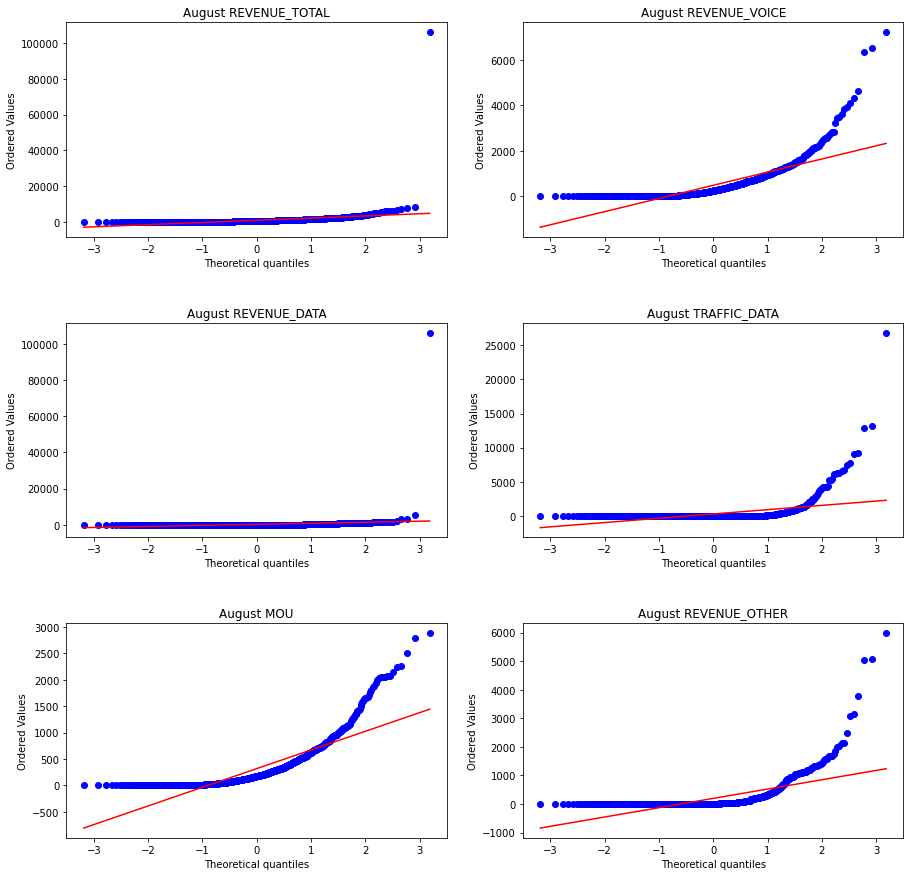

In [12]:
f, a = plt.subplots(3,2, figsize=(15,15))
a = a.flatten().T
f.subplots_adjust(wspace=0.2, hspace=0.4)
for i, col in enumerate(df_aug[features].columns):
    stats.probplot(df_aug[col], plot=a[i])
    a[i].set_title(f'August {col}')
plt.show()

### September QQ plots

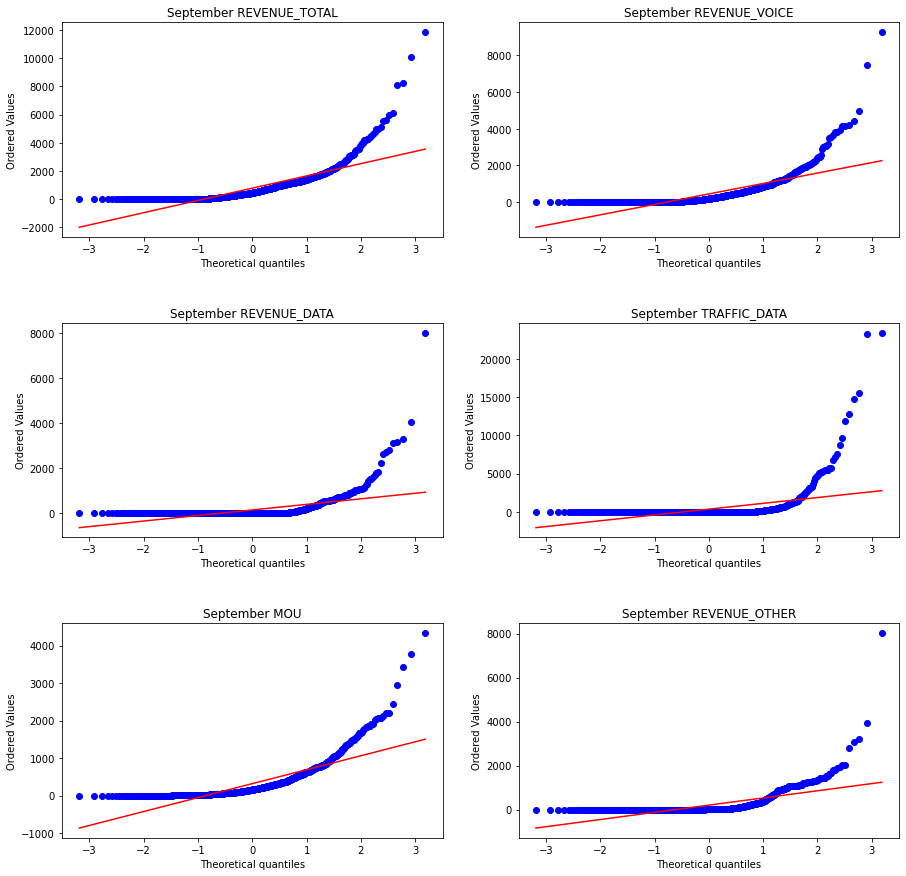

In [13]:
f, a = plt.subplots(3,2, figsize=(15,15))
a = a.flatten().T
f.subplots_adjust(wspace=0.2, hspace=0.4)
for i, col in enumerate(df_sep[features].columns):
    stats.probplot(df_sep[col], plot=a[i])
    a[i].set_title(f'September {col}')
plt.show()

#### From these probability graphs, we can see that every feature in both datasets has some outliers that's why in the further analysis median is used as the measure of central tendency

### Two months Total Revenue Comparison

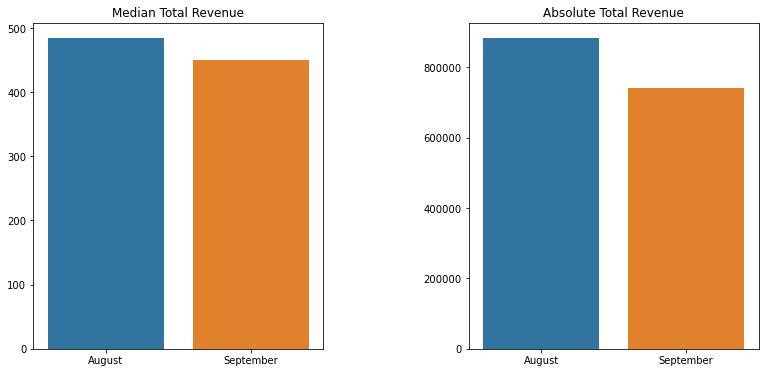

In [14]:
months = ['August', 'September']
titles = ['Median Total Revenue', 'Absolute Total Revenue']
medians = [df_aug['REVENUE_TOTAL'].median(), df_sep['REVENUE_TOTAL'].median()]
absolute = [df_aug['REVENUE_TOTAL'].sum(), df_sep['REVENUE_TOTAL'].sum()]
charts = [medians, absolute]

plt.figure(figsize = (13, 6))
for i, name in enumerate(titles, start=1):
    plt.subplot(1, 2, i)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    sns.barplot(x=months, y=charts[i-1])
    plt.title(name)

<ul><li><b>Median Total Revenue in September has dropped by ~ 7.1 % </b></li>
<li><b>Absolute Total Revenue in September has dropped by ~ 15.9 % </b></li></ul><br>
<b>(Only both months observations taken to the account)</b>

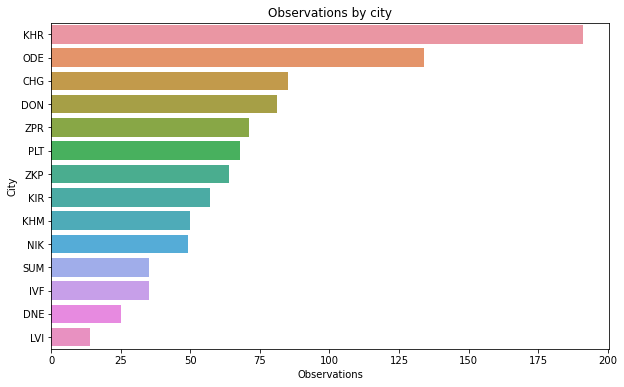

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(y='MARKET_KEY', data=df_aug, order = df_aug['MARKET_KEY'].value_counts().index)
plt.xlabel('Observations')
plt.ylabel('City')
plt.title('Observations by city')
plt.show()

<b>The sample sizes of some cities are not big enough to expect statistically right outcomes because the results for these cities will be relatively random due to the chance. </b>

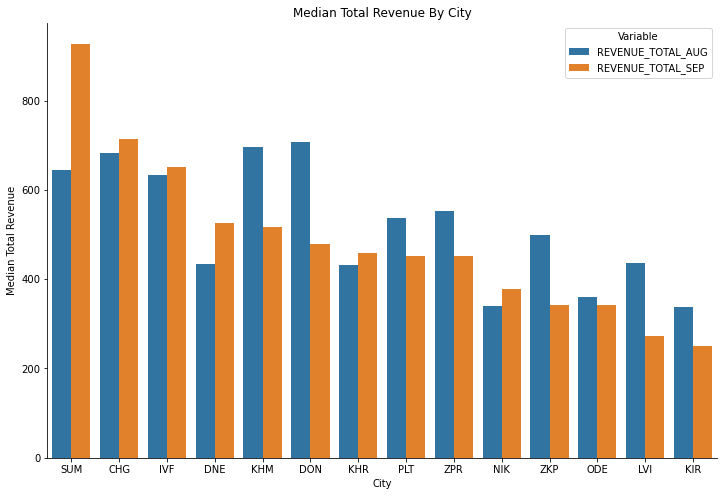

In [16]:
df1 = df_aug.groupby('MARKET_KEY')[['REVENUE_TOTAL']].median()
df2 = df_sep.groupby('MARKET_KEY')[['REVENUE_TOTAL']].median()

df1.columns+='_AUG'
df2.columns+='_SEP'

df_melted = pd.concat([df1, df2], axis=1).sort_values(by='REVENUE_TOTAL_SEP', ascending=False)
df_melted.reset_index(inplace=True)
df_melted = df_melted.melt(id_vars='MARKET_KEY').rename(columns=str.title)

fig, ax1 = plt.subplots(figsize=(12, 8))
sns.barplot(x='Market_Key', y='Value', hue='Variable', data=df_melted, ax=ax1)
plt.xlabel('City')
plt.ylabel('Median Total Revenue')
plt.title('Median Total Revenue By City')
sns.despine(fig)
plt.show()

Here we can see that some cities consistently have higher revenue than the others, so maybe a deeper analysis of the geographic segmentation would be a reasonable thing to do, but the sample sizes of the certain cities should be bigger, because so far the statistical outcomes of these cities are highly depending on a random chance

#### AFTER SOME DATA ANALYSIS I SAW AN INTERESTING OPPORTUNITY TO SEGMENT CUSTOMER BY TRAFFIC_DATA FEATURE.<br>
<b>THERE ARE 4 GROUPS BASED ON THE INTERNET USAGE:</b>
    <ol><li><b>THOSE WHO DIDN'T USE INTERNET BOTH IN AUG & SEP -> -- </li></b>
    <li><b> THOSE WHO USED IN AUG AND DIDN'T IN SEP -> +- </li></b>
    <li><b> THOSE WHO DIDN'T USE IN AUG AND USED IN SEP -> -+ </li></b>
    <li><b> AND THOSE WHO USED IN BOTH MONTHS -> ++ </b></li></ol>

In [17]:
# ADDING EXTRA FEATURE -> INTERNET_GROUP
all_users = set(df_aug.index)
aug_internet_users = set(df_aug[df_aug['TRAFFIC_DATA']>0].index)
sep_internet_users = set(df_sep[df_sep['TRAFFIC_DATA']>0].index)

both_month_users = aug_internet_users & sep_internet_users
only_aug_users = aug_internet_users - sep_internet_users
only_sep_users = sep_internet_users - aug_internet_users
never_used = all_users - aug_internet_users - sep_internet_users

df_aug['INTERNET_GROUP'] = ''
df_sep['INTERNET_GROUP'] = ''
internet_group_dict = {'++': both_month_users,
                       '--': never_used,
                       '-+': only_sep_users,
                       '+-': only_aug_users}

for group_name, indexes in internet_group_dict.items():
    df_aug.loc[indexes, 'INTERNET_GROUP'] = group_name
    df_sep.loc[indexes, 'INTERNET_GROUP'] = group_name

df_aug['INTERNET_GROUP'].value_counts()

--    498
++    284
+-     95
-+     82
Name: INTERNET_GROUP, dtype: int64

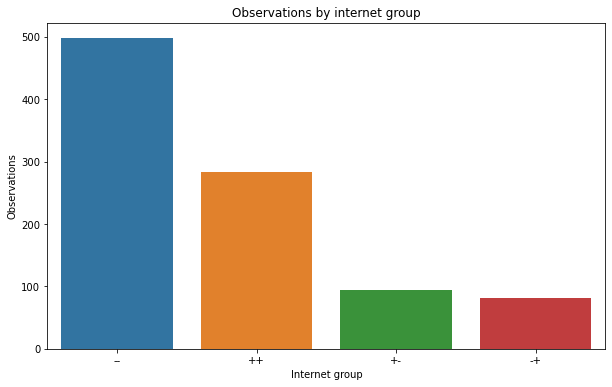

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(x='INTERNET_GROUP', data=df_aug, order = df_aug['INTERNET_GROUP'].value_counts().index)
plt.ylabel('Observations')
plt.xlabel('Internet group')
plt.title('Observations by internet group')
plt.show()

#### Amount of people who stopped using internet in September is slightly bigger than amount of those who started

In [19]:
df_aug_cp = df_aug.copy()
df_sep_cp = df_sep.copy()

df_aug_cp.drop(['MARKET_KEY', 'SUBS_ACTIVATION_DATE_KEY'], axis=1, inplace=True)
df_sep_cp.drop(['MARKET_KEY', 'SUBS_ACTIVATION_DATE_KEY'], axis=1, inplace=True)

df_aug_cp.columns += '_AUG'
df_sep_cp.columns += '_SEP'

together = pd.concat([df_aug_cp, df_sep_cp], axis=1)
together.drop('INTERNET_GROUP_SEP', axis=1, inplace=True)
together.rename({'INTERNET_GROUP_AUG': 'INTERNET_GROUP'}, axis=1, inplace=True)

together.head()

,REVENUE_TOTAL_AUG,REVENUE_VOICE_AUG,REVENUE_DATA_AUG,TRAFFIC_DATA_AUG,MOU_AUG,REVENUE_OTHER_AUG,INTERNET_GROUP,REVENUE_TOTAL_SEP,REVENUE_VOICE_SEP,REVENUE_DATA_SEP,TRAFFIC_DATA_SEP,MOU_SEP,REVENUE_OTHER_SEP
ID,,,,,,,,,,,,,
1,11.075,6.562,4.513,0.247,40.250,-0.000,+-,0.000,0.000,0.000,0.0,0.600,0.000
2,1940.036,1090.420,1.402,0.077,445.882,848.214,+-,1931.732,503.161,0.000,0.0,495.283,1428.571
3,1127.000,631.242,0.000,0.000,333.233,495.758,--,549.937,315.117,0.000,0.0,471.883,234.820
4,142.286,142.286,0.000,0.000,479.000,0.000,--,683.527,652.777,0.000,0.0,666.750,30.750
5,473.233,169.661,44.643,0.000,131.884,258.929,--,666.732,357.911,44.643,0.0,112.383,264.178


In [20]:
together_median = together.groupby('INTERNET_GROUP').median()
together_sum = together.groupby('INTERNET_GROUP').sum()

together_median

,REVENUE_TOTAL_AUG,REVENUE_VOICE_AUG,REVENUE_DATA_AUG,TRAFFIC_DATA_AUG,MOU_AUG,REVENUE_OTHER_AUG,REVENUE_TOTAL_SEP,REVENUE_VOICE_SEP,REVENUE_DATA_SEP,TRAFFIC_DATA_SEP,MOU_SEP,REVENUE_OTHER_SEP
INTERNET_GROUP,,,,,,,,,,,,
++,980.871,247.8665,155.7815,81.555,246.9665,40.822,932.3930,146.6965,116.4290,89.0060,235.9330,40.572
+-,625.991,272.8130,5.1880,0.418,170.3830,25.000,314.5520,170.5180,0.0000,0.0000,137.3000,2.901
-+,296.254,205.9335,0.0000,0.000,198.9170,0.000,660.6615,240.7190,3.3975,1.2305,218.9905,15.625
--,360.379,263.3880,0.0000,0.000,145.9415,0.000,311.0315,202.1830,0.0000,0.0000,130.5585,0.000


In [21]:
def charts(sign, df1, df2, data_type1, data_type2, group):
    
    months = ['August', 'September']
    titles = [f'{data_type1} Total Revenue', f'{data_type1} Data Revenue', 
              f'{data_type1} Voice Revenue', f'{data_type1} Other Revenue',
              f'{data_type2} Total Revenue', f'{data_type2} Data Revenue', 
              f'{data_type2} Voice Revenue', f'{data_type2} Other Revenue']
    
    rv_total1 = [df1.loc[sign, 'REVENUE_TOTAL_AUG'], df1.loc[sign, 'REVENUE_TOTAL_SEP']]
    rv_data1 = [df1.loc[sign, 'REVENUE_DATA_AUG'], df1.loc[sign, 'REVENUE_DATA_SEP']]
    rv_voice1 = [df1.loc[sign, 'REVENUE_VOICE_AUG'], df1.loc[sign, 'REVENUE_VOICE_SEP']]
    rv_other1 = [df1.loc[sign, 'REVENUE_OTHER_AUG'], df1.loc[sign, 'REVENUE_OTHER_SEP']]
    rv_total2 = [df2.loc[sign, 'REVENUE_TOTAL_AUG'], df2.loc[sign, 'REVENUE_TOTAL_SEP']]
    rv_data2 = [df2.loc[sign, 'REVENUE_DATA_AUG'], df2.loc[sign, 'REVENUE_DATA_SEP']]
    rv_voice2 = [df2.loc[sign, 'REVENUE_VOICE_AUG'], df2.loc[sign, 'REVENUE_VOICE_SEP']]
    rv_other2 = [df2.loc[sign, 'REVENUE_OTHER_AUG'], df2.loc[sign, 'REVENUE_OTHER_SEP']]
    charts = [rv_total1, rv_data1, rv_voice1, rv_other1, rv_total2, rv_data2, rv_voice2, rv_other2]

    plt.figure(figsize = (15, 8))
    for i, name in enumerate(titles, start=1):
        plt.subplot(2, 4, i)
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        sns.barplot(x=months, y=charts[i-1])
        sns.despine()
        plt.title(name)
        
    plt.suptitle(f'{sign} {group} GROUP')
    plt.show()

### Revenue Charts For Every Internet Segment

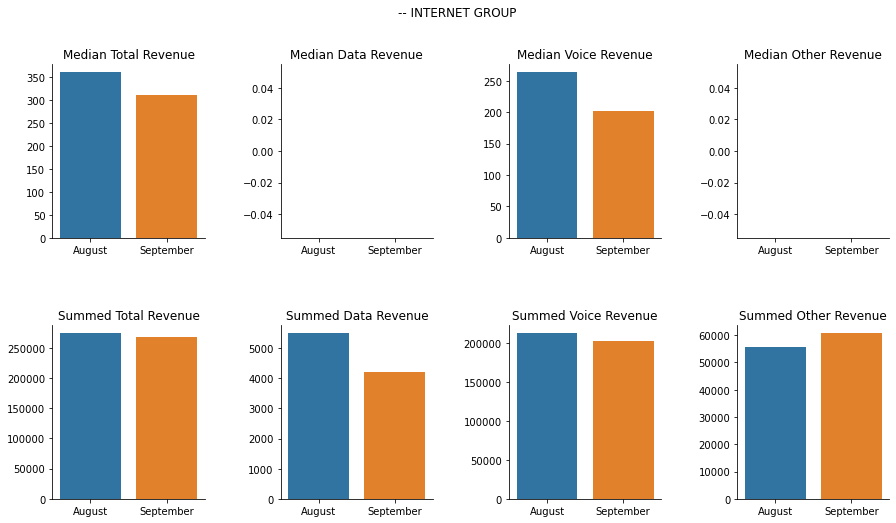

In [22]:
charts('--', together_median, together_sum, 'Median', 'Summed', 'INTERNET')

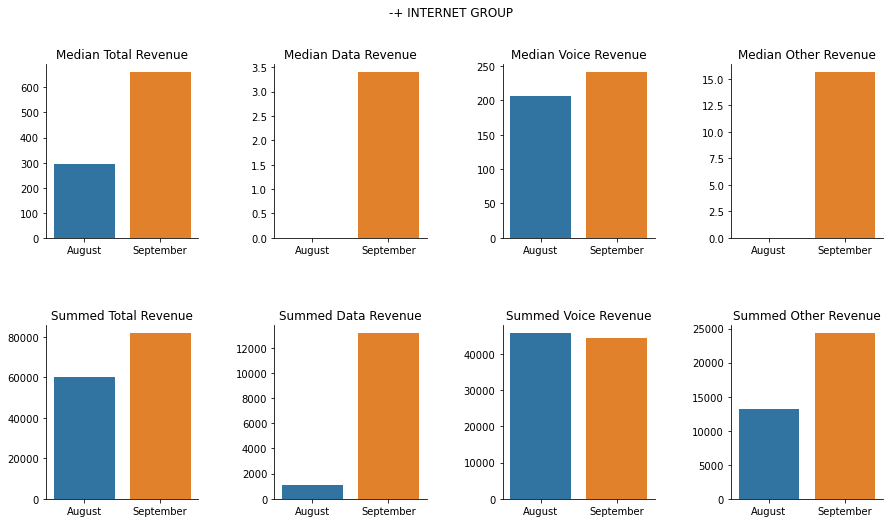

In [23]:
charts('-+', together_median, together_sum, 'Median', 'Summed', 'INTERNET')

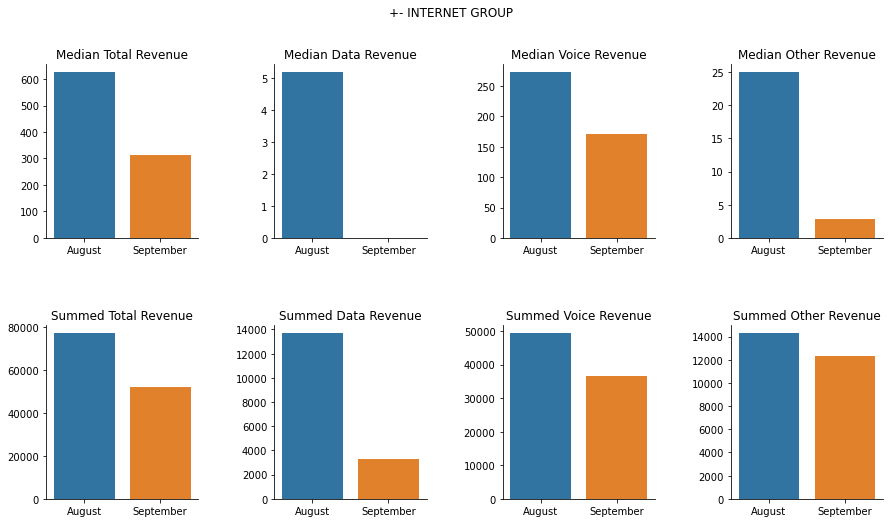

In [24]:
charts('+-', together_median, together_sum, 'Median', 'Summed', 'INTERNET')

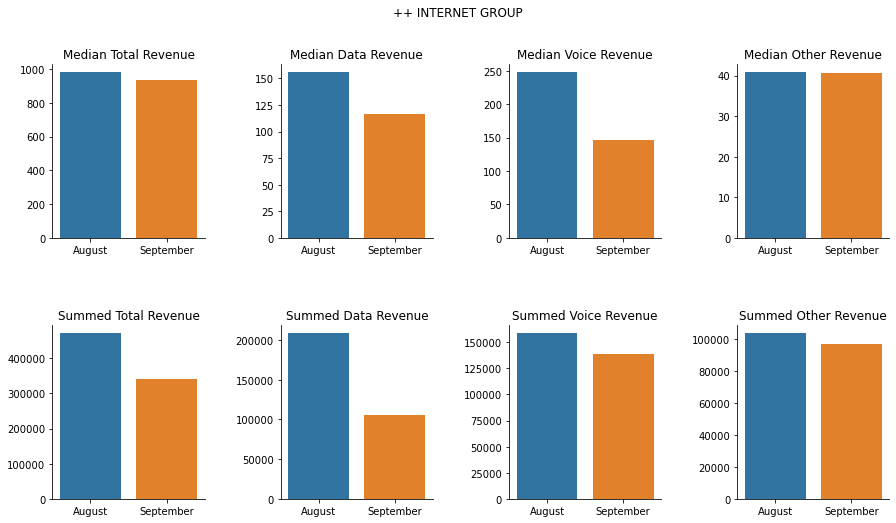

In [25]:
charts('++', together_median, together_sum, 'Median', 'Summed', 'INTERNET')

### Melting the data for group comparison charts

In [26]:
tm_melted = together_median.copy()
tm_melted.reset_index(inplace=True)
tm_melted = tm_melted.melt(id_vars='INTERNET_GROUP').rename(columns=str.title)

ts_melted = together_sum.copy()
ts_melted.reset_index(inplace=True)
ts_melted = ts_melted.melt(id_vars='INTERNET_GROUP').rename(columns=str.title)

ts_melted.head()

,Internet_Group,Variable,Value
0,++,REVENUE_TOTAL_AUG,471387.414
1,+-,REVENUE_TOTAL_AUG,77337.453
2,-+,REVENUE_TOTAL_AUG,60079.380
3,--,REVENUE_TOTAL_AUG,274195.558
4,++,REVENUE_VOICE_AUG,158776.397


In [27]:
def final_charts(df, charts_type, groupped_by):
    
    plt.figure(figsize = (10, 25))
    variables = ['REVENUE_TOTAL', 'REVENUE_VOICE', 'REVENUE_DATA', 'REVENUE_OTHER', 'TRAFFIC_DATA', 'MOU']
    
    for i, name in enumerate(variables, start=1):
        plt.subplot(6, 1, i)
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        sns.barplot(x=groupped_by, y='Value', hue='Variable', data=df[(df['Variable']==variables[i-1]+'_AUG') | (df['Variable']==variables[i-1]+'_SEP')])
        sns.despine()
        plt.title(f'{charts_type} {name} By {groupped_by}')
        
    plt.show()

### Median Charts By Internet Segment

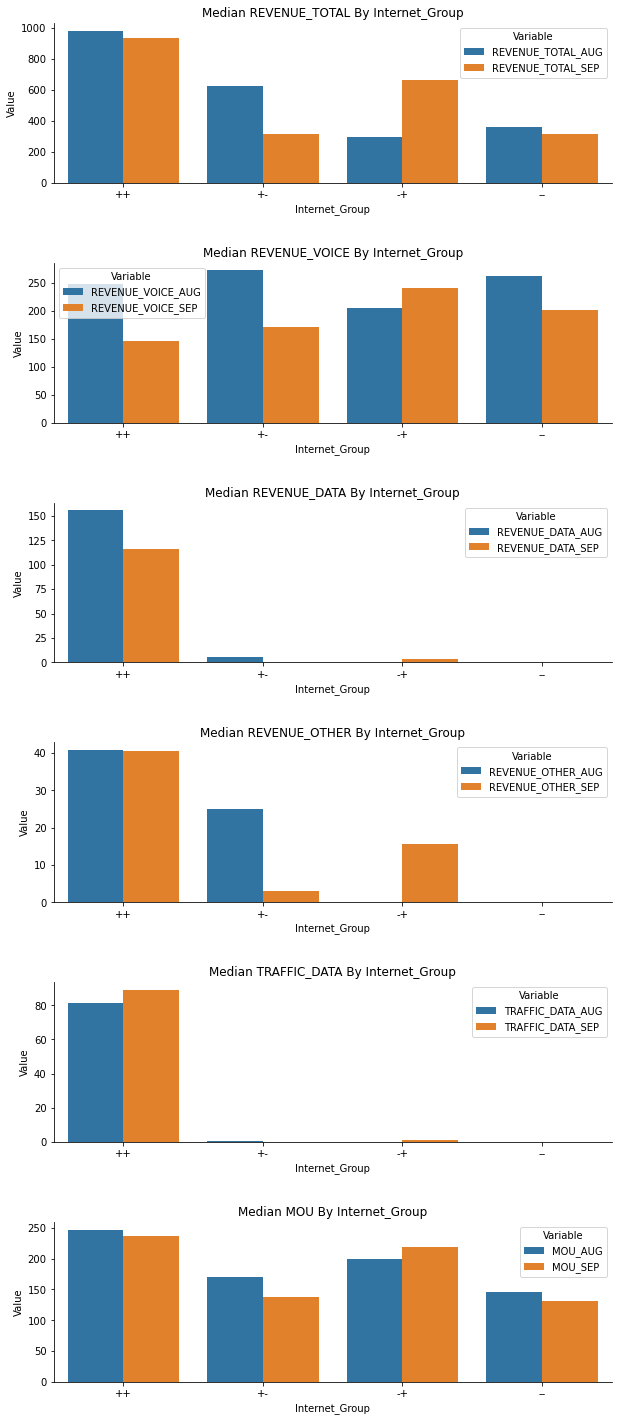

In [28]:
final_charts(tm_melted, 'Median', 'Internet_Group')

### Summed Charts By Internet Segment

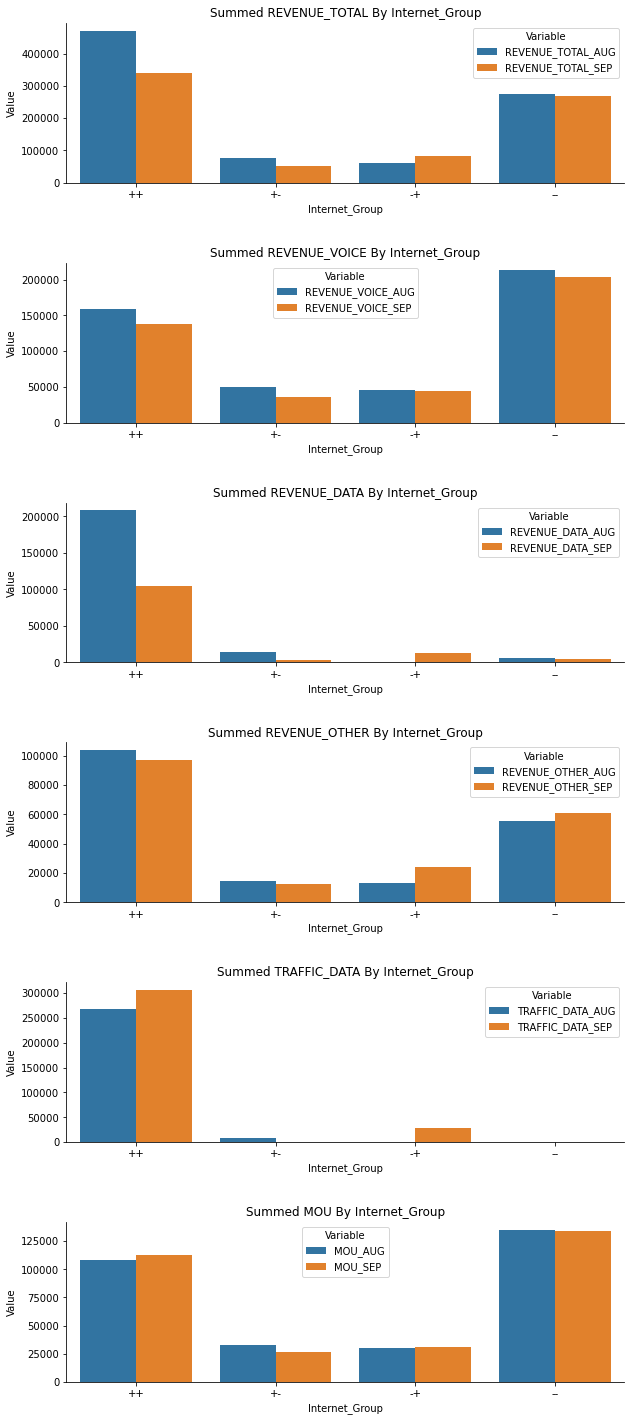

In [29]:
final_charts(ts_melted, 'Summed', 'Internet_Group')

So as we can see on the last 3 charts those who are consistant internet users on average have 3 times bigger total revenue than those who have 0 traffic data, but most of that difference comes from the different sources of income because the median voice revenue is more or less equal from segment to segment and the data revenue covers only a small part of that revenue difference

 There is a clear correlation between using/not using internet and revenue, because as we can see even for groups that switched from using internet to not using in the next month and vice versa, the median income would change almost 2x. So this kind of segmentation needs more analysis with the bigger datasets.
 I don't think that we can figure out what's the cause and what's the consequance with this data because of it having observation only for 2 months

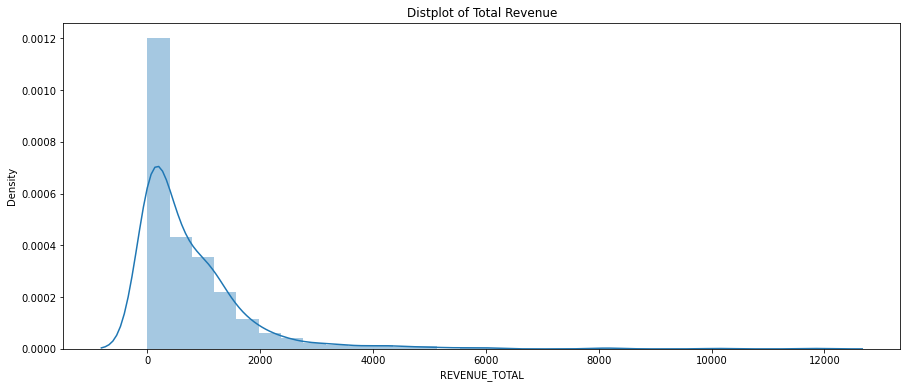

In [30]:
plt.figure(figsize=(15, 6))
sns.distplot(df_sep['REVENUE_TOTAL'], bins=30)
plt.title(f'Distplot of Total Revenue')
plt.show()

From the Total Revenue density plot we can see that it's distribution is right-skewed -> there most likely is the small cluster of customers which brings the most money hence ARPU customer segmentation might also be a good choice in this case

K-means segmentation by ARPU over 2 month period

In [31]:
arpu = (df_aug['REVENUE_TOTAL'] + df_sep['REVENUE_TOTAL'])/2

# Removing 1 outlier from the data -> dataset length is 958 now
the_outlier = arpu[arpu > 50000]
arpu = arpu[arpu < 50000]
arpu

ID
1          5.5375
2       1935.8840
3        838.4685
4        412.9065
5        569.9825
          ...    
1055     418.1560
1056       0.0000
1057    1636.4070
1058    1180.2460
1059     886.8210
Name: REVENUE_TOTAL, Length: 958, dtype: float64

In [32]:
# removed outlier
the_outlier

ID
362    53564.065
Name: REVENUE_TOTAL, dtype: float64

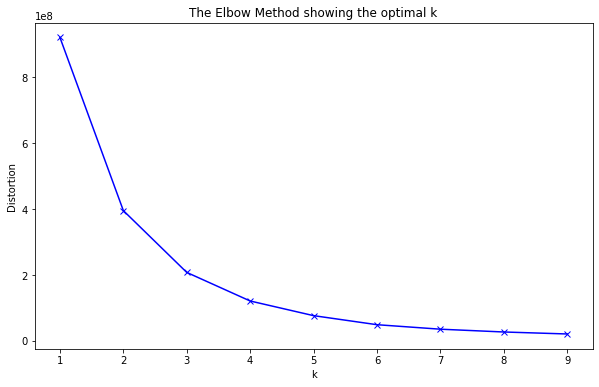

In [33]:
arpu_arr = arpu.copy()
arpu_arr = np.array(arpu_arr).reshape(-1, 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(arpu_arr)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Optimal amount of clusters = 4

In [34]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(arpu_arr)

df_arpu = arpu.copy()
df_arpu = pd.DataFrame(df_arpu)
df_arpu['k_means']=kmeanModel.predict(df_arpu)

# fixing wrong group ordering
for i in range(3):
    if len(df_arpu[df_arpu['k_means']==i+1]) > len(df_arpu[df_arpu['k_means']==i]):
        group_1, group_2 = df_arpu[df_arpu['k_means']==i].index, df_arpu[df_arpu['k_means']==i+1].index
        df_arpu.loc[group_1, 'k_means'], df_arpu.loc[group_2, 'k_means'] = i+1, i

# adding the outlier back to the most profitable group (3)
df_arpu.loc[the_outlier.index[0], :] = [the_outlier.values[0], 3]
df_arpu = df_arpu.astype({'k_means': 'int8'})

df_arpu['k_means'].value_counts()

0    600
1    291
2     59
3      9
Name: k_means, dtype: int64

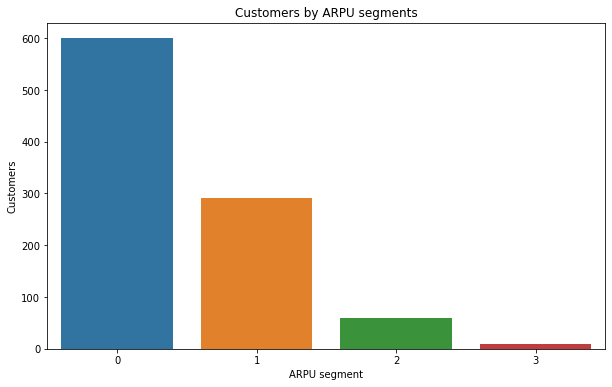

In [35]:
plt.figure(figsize=(10,6))
sns.countplot(x='k_means', data=df_arpu, order = df_arpu['k_means'].value_counts().index)
plt.ylabel('Customers')
plt.xlabel('ARPU segment')
plt.title('Customers by ARPU segments')
plt.show()

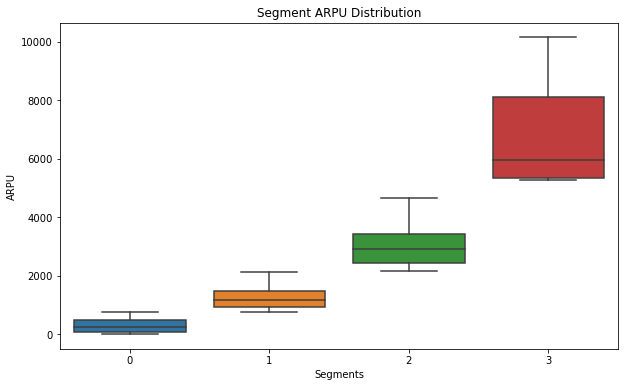

In [36]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="k_means", y="REVENUE_TOTAL", data=df_arpu[df_arpu['REVENUE_TOTAL']<50000])
plt.xlabel('Segments')
plt.ylabel('ARPU')
plt.title('Segment ARPU Distribution')
plt.show()

Above chart has the outlier excluded from the data

In [37]:
together_kmeans = pd.concat([df_aug_cp, df_sep_cp], axis=1)
together_kmeans = together_kmeans.loc[df_arpu.index, :]
together_kmeans['ARPU_GROUP'] = df_arpu['k_means']

together_kmeans.head()

,REVENUE_TOTAL_AUG,REVENUE_VOICE_AUG,REVENUE_DATA_AUG,TRAFFIC_DATA_AUG,MOU_AUG,REVENUE_OTHER_AUG,INTERNET_GROUP_AUG,REVENUE_TOTAL_SEP,REVENUE_VOICE_SEP,REVENUE_DATA_SEP,TRAFFIC_DATA_SEP,MOU_SEP,REVENUE_OTHER_SEP,INTERNET_GROUP_SEP,ARPU_GROUP
ID,,,,,,,,,,,,,,,
1,11.075,6.562,4.513,0.247,40.250,-0.000,+-,0.000,0.000,0.000,0.0,0.600,0.000,+-,0
2,1940.036,1090.420,1.402,0.077,445.882,848.214,+-,1931.732,503.161,0.000,0.0,495.283,1428.571,+-,1
3,1127.000,631.242,0.000,0.000,333.233,495.758,--,549.937,315.117,0.000,0.0,471.883,234.820,--,1
4,142.286,142.286,0.000,0.000,479.000,0.000,--,683.527,652.777,0.000,0.0,666.750,30.750,--,0
5,473.233,169.661,44.643,0.000,131.884,258.929,--,666.732,357.911,44.643,0.0,112.383,264.178,--,0


In [38]:
km_median = together_kmeans.groupby('ARPU_GROUP').median()
km_sum = together_kmeans.groupby('ARPU_GROUP').sum()

km_median

,REVENUE_TOTAL_AUG,REVENUE_VOICE_AUG,REVENUE_DATA_AUG,TRAFFIC_DATA_AUG,MOU_AUG,REVENUE_OTHER_AUG,REVENUE_TOTAL_SEP,REVENUE_VOICE_SEP,REVENUE_DATA_SEP,TRAFFIC_DATA_SEP,MOU_SEP,REVENUE_OTHER_SEP
ARPU_GROUP,,,,,,,,,,,,
0,207.1205,116.0935,0.000,0.000,86.6835,0.000,175.5755,63.1565,0.000,0.000,71.7585,0.000
1,1229.7950,701.7410,0.054,0.008,355.0000,74.000,1163.1520,513.9100,0.000,0.001,369.6500,123.437
2,2993.9220,1528.2320,48.286,11.381,567.1670,361.608,2754.3590,1326.1320,34.232,0.703,619.0500,300.893
3,6599.5400,4317.9480,107.795,0.379,868.2830,491.858,5639.8940,3842.2310,943.910,52.638,910.5830,472.322


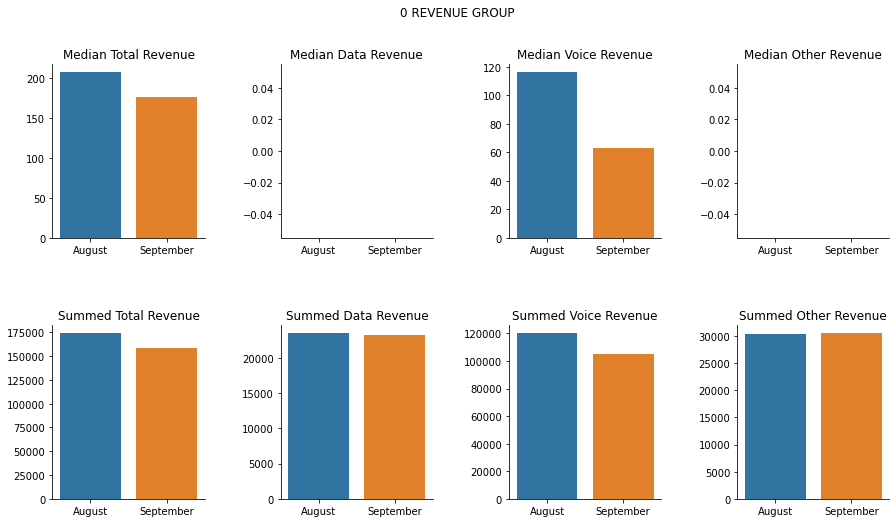

In [39]:
charts(0, km_median, km_sum, 'Median', 'Summed', 'REVENUE')

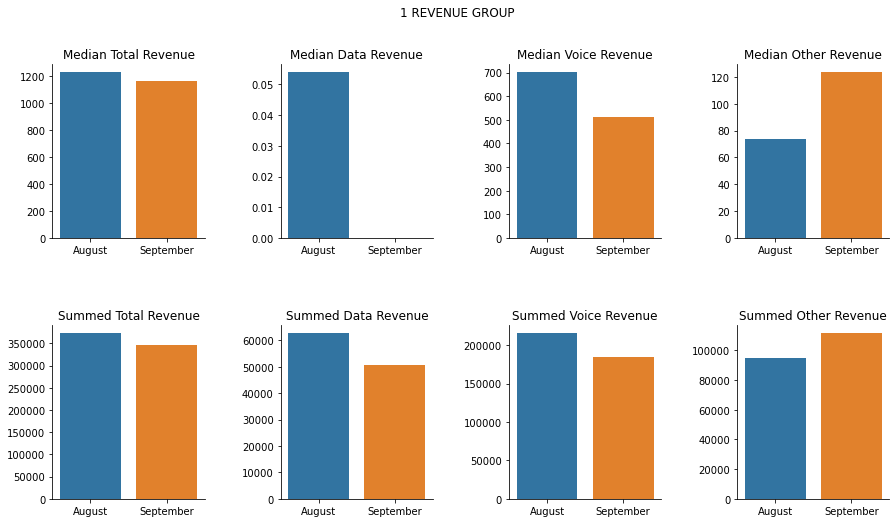

In [46]:
charts(1, km_median, km_sum, 'Median', 'Summed', 'REVENUE')

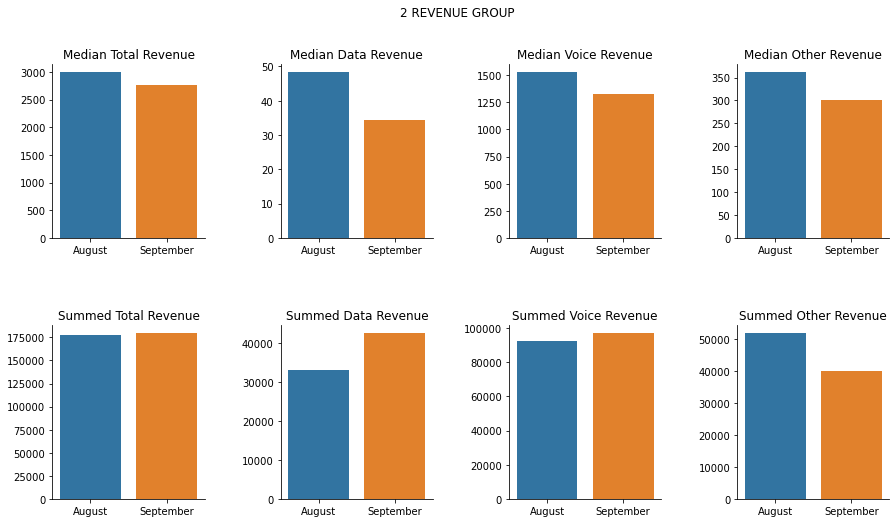

In [47]:
charts(2, km_median, km_sum, 'Median', 'Summed', 'REVENUE')

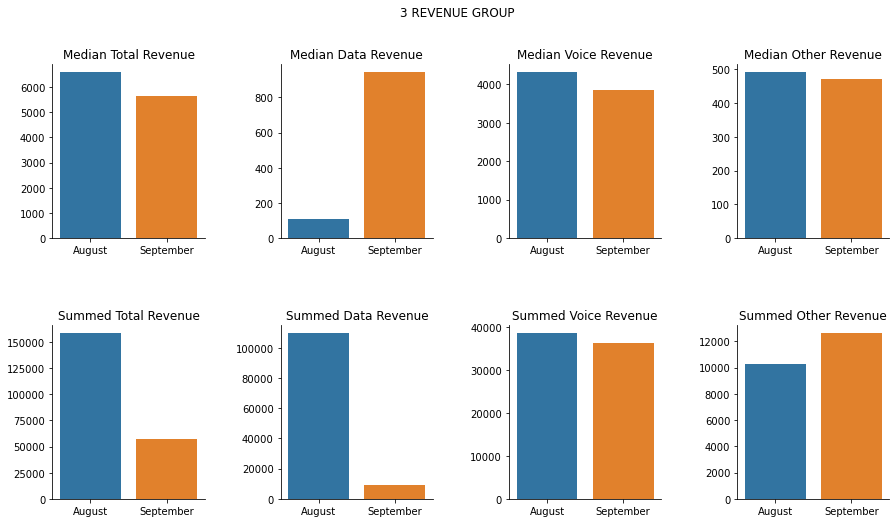

In [41]:
charts(3, km_median, km_sum, 'Median', 'Summed', 'REVENUE')

In [42]:
km_m_melted = km_median.copy()
km_m_melted.reset_index(inplace=True)
km_m_melted = km_m_melted.melt(id_vars='ARPU_GROUP').rename(columns=str.title)

km_s_melted = km_sum.copy()
km_s_melted.reset_index(inplace=True)
km_s_melted = km_s_melted.melt(id_vars='ARPU_GROUP').rename(columns=str.title)

km_m_melted.head()

,Arpu_Group,Variable,Value
0,0,REVENUE_TOTAL_AUG,207.1205
1,1,REVENUE_TOTAL_AUG,1229.7950
2,2,REVENUE_TOTAL_AUG,2993.9220
3,3,REVENUE_TOTAL_AUG,6599.5400
4,0,REVENUE_VOICE_AUG,116.0935


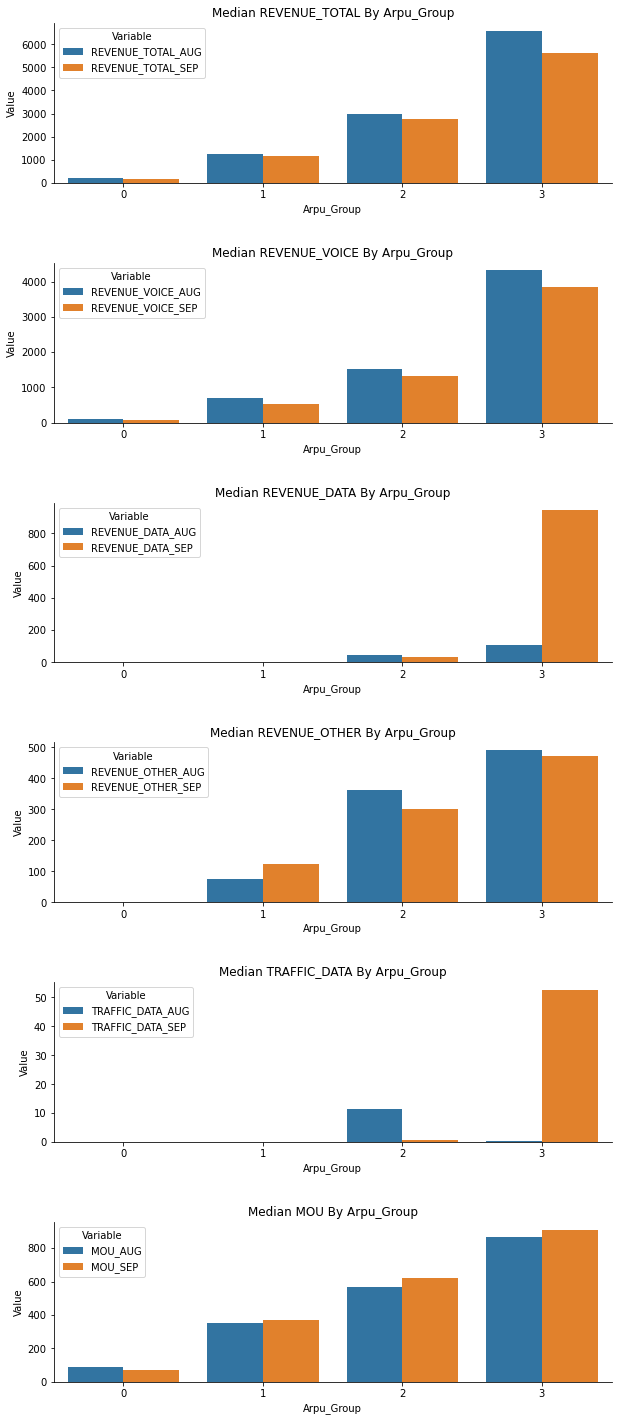

In [43]:
final_charts(km_m_melted, 'Median', 'Arpu_Group')

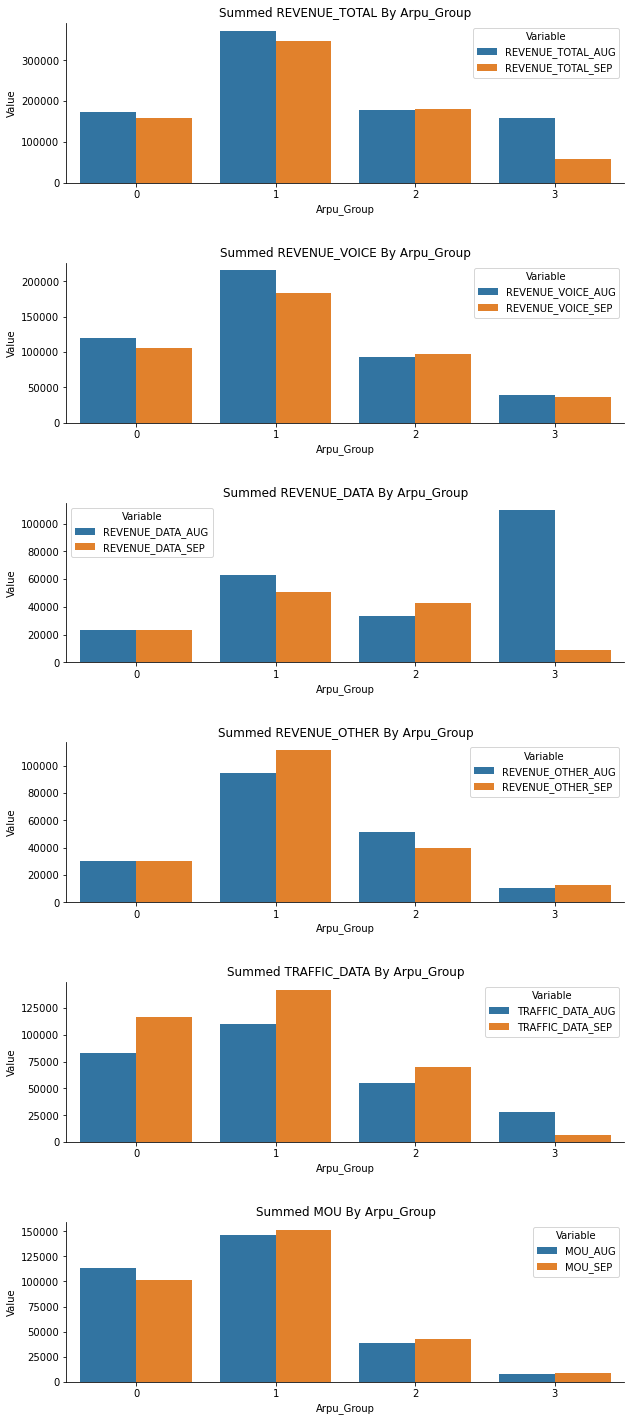

In [44]:
final_charts(km_s_melted, 'Summed', 'Arpu_Group')